In [63]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import norm 
from sklearn.preprocessing import StandardScaler
from scipy import stats

In [64]:
#导入数据
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')


In [65]:
train_df.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


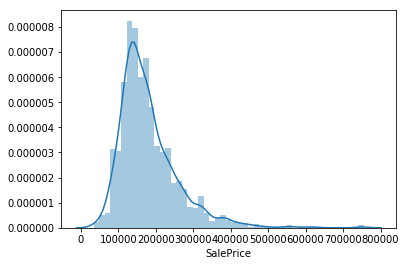

6.5362818600645287

In [66]:
#预测值SalePrice的基本信息
train_df['SalePrice'].describe()

sns.distplot(train_df['SalePrice'])
plt.show()

train_df['SalePrice'].skew()
train_df['SalePrice'].kurt()

 #有长尾和离散点，左偏

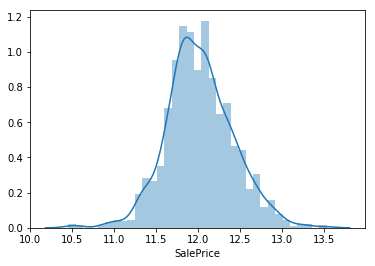

In [67]:
#将SalePrice取对数后，比较符合正正态分布，所以将SalePrice的对数作为目标值
sns.distplot(np.log1p(train_df['SalePrice']))
plt.show()

In [68]:
#将SalePrice进行log1p转化后作为目标值
train_df['SalePrice'] = np.log1p(train_df['SalePrice'])

In [69]:
categorical_feature = train_df.select_dtypes(include=['object']).columns
numeric_feature = train_df.dtypes[train_df.dtypes!='object'].index

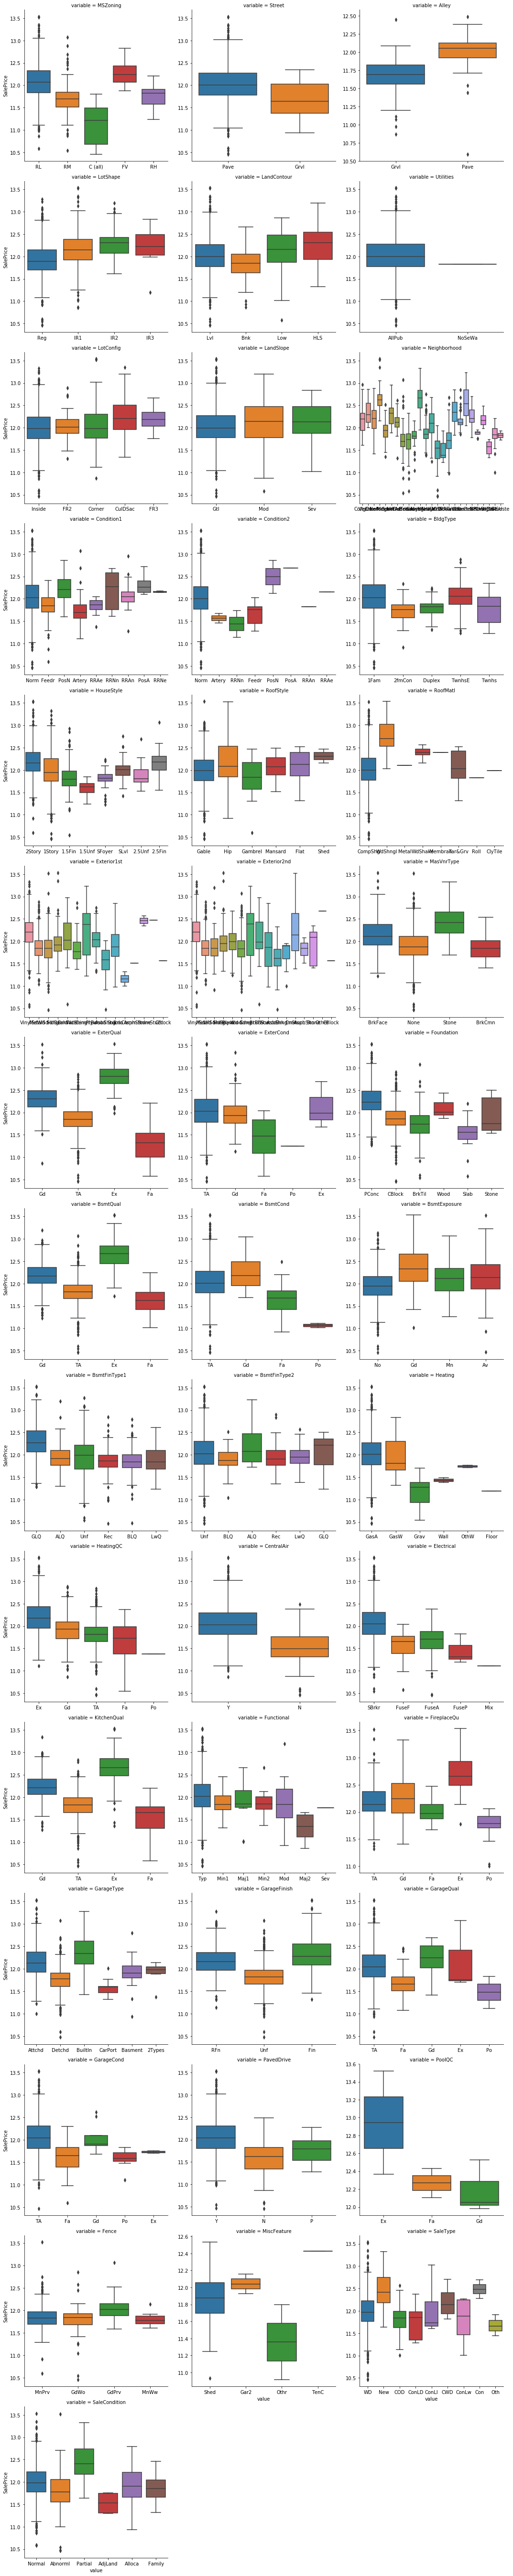

In [70]:
#单因素分析

#查看类别特征与SalePrice之间的关系
  
for c in categorical_feature:
    train_df[c] = train_df[c].astype('category')

def boxplot(x, y, **kwargs):
    sns.boxplot(x=x, y=y)
    
f = pd.melt(train_df, id_vars=['SalePrice'], value_vars = categorical_feature)
g = sns.FacetGrid(f, col="variable", col_wrap=3, sharex=False, sharey=False, size=5)
g = g.map(boxplot,"value","SalePrice")
plt.show()

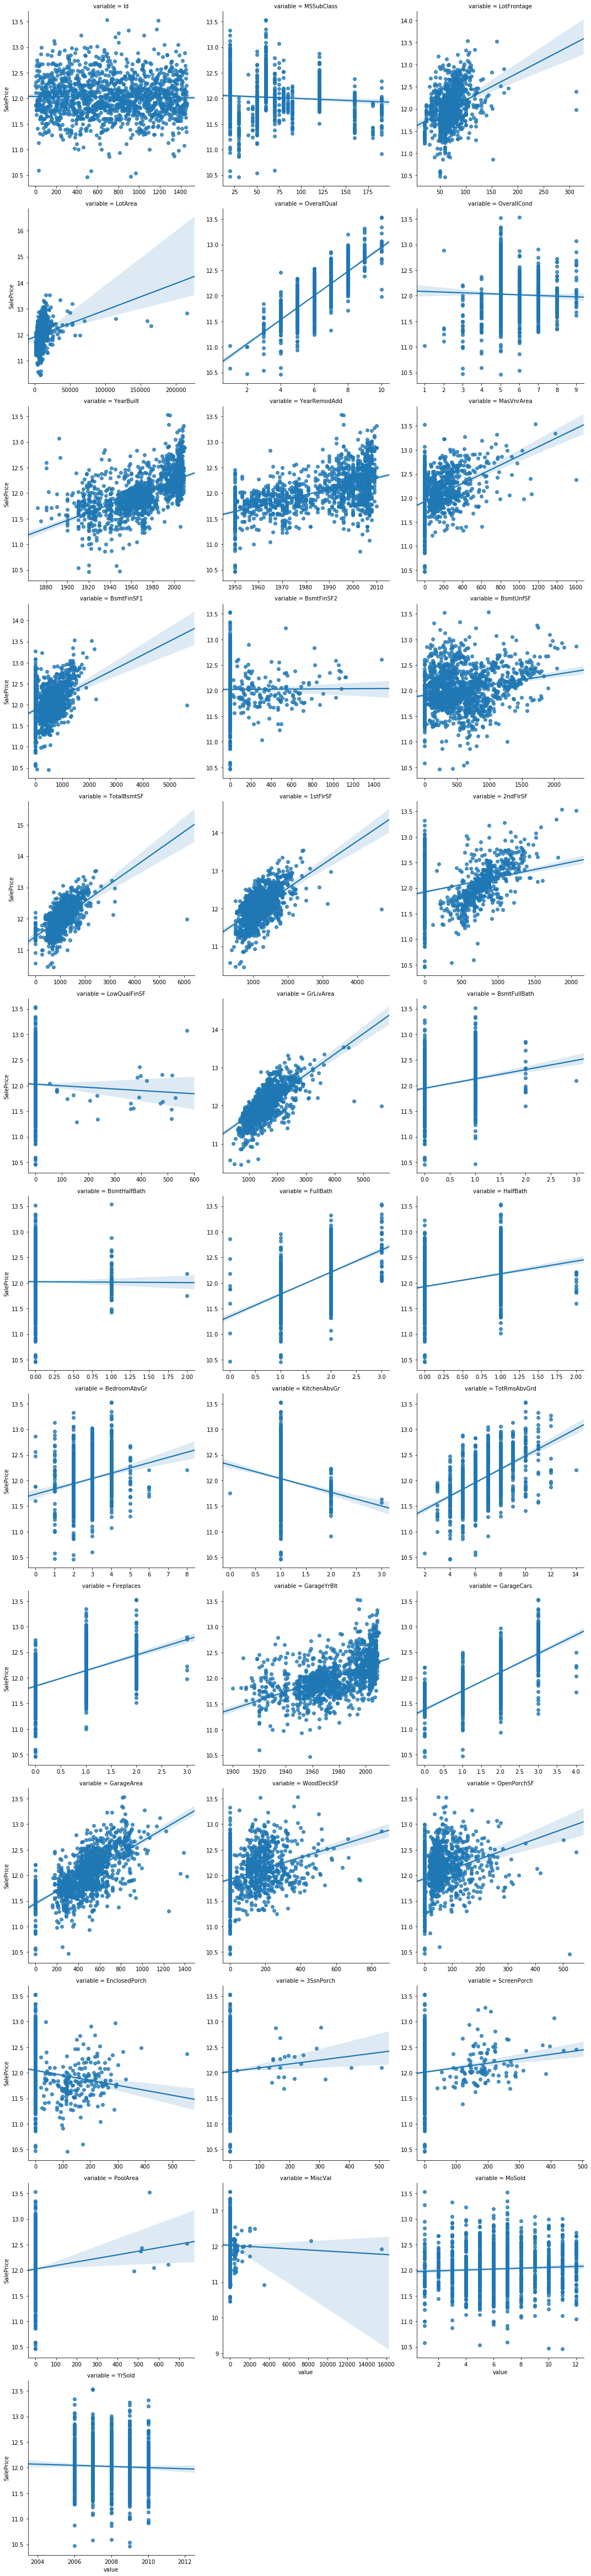

In [71]:
#查看数值特征与SalePrice之间的关系

def jointplot(x,y,**kwargs):
    try:
        sns.regplot(x=x, y=y)
    except Exception:
        print(x.value.counts())
numeric_feature = numeric_feature.drop("SalePrice")
f = pd.melt(train_df, id_vars=['SalePrice'], value_vars=numeric_feature)
g = sns.FacetGrid(f, col="variable", col_wrap=3, sharex=False, sharey=False, size=5)
g = g.map(jointplot, "value", "SalePrice")
plt.show()

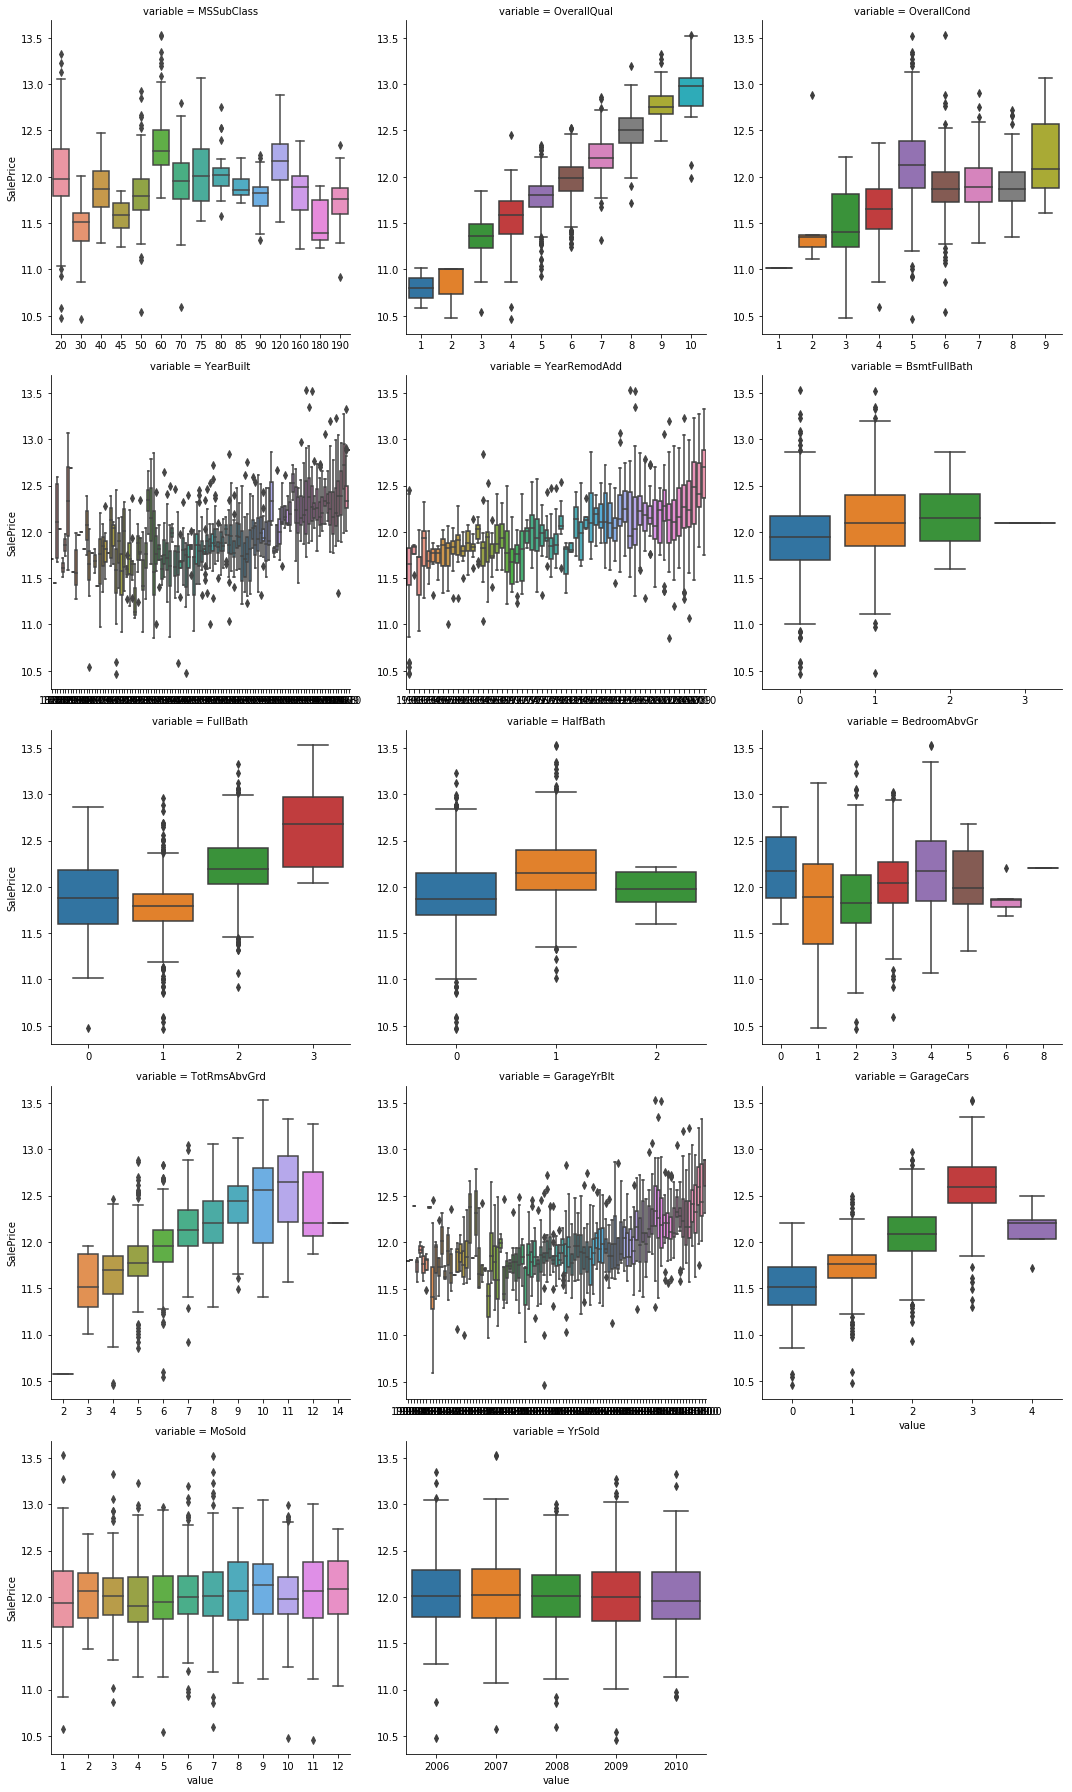

In [72]:
#从图上可以看出，"MSSubClass",'OverallQual'等变量和SalePrice没有明显线性关系，它们虽然是数值型的，但其实是类别特征
nomial_f = ['MSSubClass','OverallQual','OverallCond','YearBuilt','YearRemodAdd','BsmtFullBath','FullBath','HalfBath',
             'BedroomAbvGr','TotRmsAbvGrd','GarageYrBlt','GarageCars','MoSold','YrSold']
 
for c in nomial_f:
    train_df[c] = train_df[c].astype('category')

f = pd.melt(train_df, id_vars=['SalePrice'], value_vars=nomial_f)
g = sns.FacetGrid(f, col="variable", col_wrap=3, sharex=False, sharey=False, size=5)
g = g.map(boxplot, "value", "SalePrice")
plt.show()


In [73]:
#可以看出Utilities取值比较单一，可以剔除,GrLivArea有两个离群值


train_df.drop(train_df[(train_df['GrLivArea'] > 4000) & (train_df['SalePrice'] < 300000)].index, inplace=True)

all_data = pd.concat([train_df.loc[:, "MSSubClass" : "SaleCondition"],test_df.loc[:, "MSSubClass" : "SaleCondition"]])
all_data.drop('Utilities',axis=1, inplace=True)

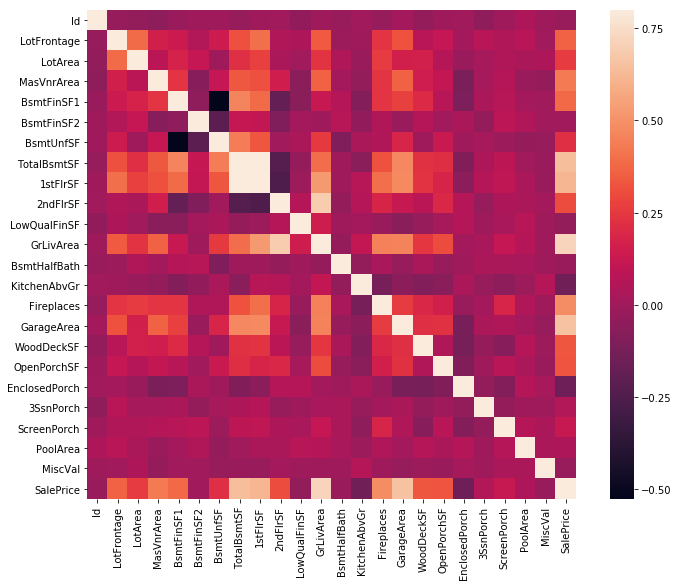

In [74]:
#多因素分析（变量相关性）
corr = train_df.corr()
f, ax= plt.subplots(figsize=(12, 9))
sns.heatmap(corr, vmax=.8, square=True)
plt.show()

In [75]:
#TotalBsmtSF和1stFlrSF、GarageCars和GarageArea、YearBuilt和GarageYrBlt、TotRmsAbvGrd和GrLivArea关联性较高，保留一个即可


all_data.drop(['1stFlrSF', 'GarageArea', 'GarageYrBlt', 'TotRmsAbvGrd'], axis=1, inplace=True)


In [76]:
price_dict = corr['SalePrice'].to_dict()
del price_dict['SalePrice']
for cor in sorted(price_dict.items(),key = lambda x: -abs(x[1])):
    print("{0} :\t{1}".format(*cor))


GrLivArea :	0.7188444008280218
GarageArea :	0.6552115300468107
TotalBsmtSF :	0.6415527990410912
1stFlrSF :	0.6137418115023304
Fireplaces :	0.4871261471633411
MasVnrArea :	0.4300730499464191
BsmtFinSF1 :	0.38270996885590824
LotFrontage :	0.3632855519220474
WoodDeckSF :	0.33057346388959896
OpenPorchSF :	0.3270383213980328
2ndFlrSF :	0.30660539262136893
LotArea :	0.25894535702323884
BsmtUnfSF :	0.22324844607655456
EnclosedPorch :	-0.14863644095825146
KitchenAbvGr :	-0.1478905327384506
ScreenPorch :	0.12386032363261845
3SsnPorch :	0.05606490417040991
PoolArea :	0.04067878856595281
LowQualFinSF :	-0.037698309021871775
Id :	-0.020511456765109445
MiscVal :	-0.019751742213106563
BsmtHalfBath :	-0.014974018212515759
BsmtFinSF2 :	0.006419677513359299


In [77]:
#可以看出OverallQual、GrLivArea、TotalBsmtSF、GarageCars等和房价高相关
#从上述的图中可以看出GrLivArea有两个离群点（GrLivArea很大，但售价很低），删除这两个离群点

all_data.drop(['Street','SaleType','FullBath'
              ],axis=1,inplace=True)


In [78]:
#处理缺失值
missing_n = all_data.isnull().sum().sort_values(ascending=False)
missing_p = (all_data.isnull().sum()/all_data.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([missing_n, missing_p], axis=1, keys=['missing_n', 'missing_p'])

missing_data[missing_data['missing_n'] >0]


,missing_n,missing_p
PoolQC,2907,0.997256
MiscFeature,2810,0.963979
Alley,2717,0.932075
Fence,2345,0.804460
FireplaceQu,1420,0.487136
LotFrontage,486,0.166724
GarageCond,159,0.054545
GarageFinish,159,0.054545
GarageQual,159,0.054545
GarageType,157,0.053859


In [81]:
"""
"PoolQC"、"MisFeature"、"Alley"缺失值达到90%以上，删除这几个变量
Garage*相关的几个变量缺失值个数相同，应该是它们几个变量表述的是同一件事情，而GarageCars和房价高相关，可以认为Garage*相关的
的变量主要是GarageCars,其他几个变量可以删除，Bsmt*变量也类似
对于Fence、FireplaceQu、MasVnrType缺失值补充为"None"，表示没有（没有篱笆之类）
对于GarageCars，MasVnrArea缺失值补充为0，表示面积为0
"MSZoning","KitchenQual","Functional","SaleType","Electrical","Exterior1st","Exterior2nd"
对于'TotalBsmtSF','BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath'用平均值来补充，
LotFrontage用中位数来补充
"""

all_data = all_data.drop(["PoolQC","MiscFeature","Alley"], axis=1)
all_data = all_data.drop(missing_data[(missing_data['missing_n'] > 70) & (missing_data['missing_n'] < 160)].index, axis=1)


for col in ['Fence','FireplaceQu','MasVnrType']:
    all_data[col].fillna("None", inplace=True)

for col in ['GarageCars','MasVnrArea']:
    all_data[col].fillna(0, inplace=True)


for col in ["MSZoning","KitchenQual","Functional","Electrical","Exterior1st","Exterior2nd"]:
    all_data[col].fillna(all_data[col].mode()[0], inplace=True)


for col in ['TotalBsmtSF','BsmtUnfSF', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtFullBath', 'BsmtHalfBath']:
    all_data[col].fillna(all_data[col].mean(), inplace=True)

all_data['LotFrontage'] = all_data.groupby("Neighborhood")['LotFrontage'].transform(lambda x : x.fillna(x.median()))



In [82]:
#将一些数值特征转化为类别特征

for col in ['YrSold', 'MoSold', 'MSSubClass', 'HalfBath', 'BedroomAbvGr', 'GarageCars']:
    all_data[col] = all_data[col].astype(str)
 

In [95]:
"""
from scipy.special import boxcox1p
numeric_f = all_data.dtypes[all_data.dtypes != 'object'].index
skewed_f = all_data['LotFrontage'].apply(lambda x :skew())

skewed_f = skewed_f[skewed_f>0.75]

skewed_f = skewed_f.index

lam = 0.15
all_data[skewed_f] = boxcox1p(all_data[skewed_f], lam)
"""



AttributeError: 'float' object has no attribute 'skew'

In [96]:
#将一些类别变量转化为数值型

all_data = all_data.replace({
                 
                  "ExterCond" : {"NA" : -1,"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                 "ExterQual" : {"NA" : -1,"Po" : 1, "Fa" : 2, "TA": 3, "Gd": 4, "Ex" : 5},
                  "FireplaceQu" : {"NA" : -1,"No" : 0, "Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                  "Functional" : {"NA" : -1,"Sal" : 1, "Sev" : 2, "Maj2" : 3, "Maj1" : 4, "Mod": 5, 
                                         "Min2" : 6, "Min1" : 7, "Typ" : 8},
                 "HeatingQC" : {"NA" : -1,"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                 "KitchenQual" : {"NA" : -1,"Po" : 1, "Fa" : 2, "TA" : 3, "Gd" : 4, "Ex" : 5},
                 "LandSlope" : {"NA" : -1,"Sev" : 1, "Mod" : 2, "Gtl" : 3},
                "LotShape" : {"NA" : -1,"IR3" : 1, "IR2" : 2, "IR1" : 3, "Reg" : 4},
               "PoolQC" : {"NA" : -1,"No" : 0, "Fa" : 1, "TA" : 2, "Gd" : 3, "Ex" : 4},
               
                           }) 

In [97]:
#对类别特征进行onehot-encode,转化为数值标签

category = all_data.dtypes[all_data.dtypes == 'object'].index

for col in category:
    for_dummy = all_data.pop(col)
    extra_data = pd.get_dummies(for_dummy, prefix=col)
    all_data = pd.concat([all_data, extra_data], axis=1)
    

In [98]:
"""
from sklearn.preprocessing import RobustScaler
N = RobustScaler()
scale_features = N.fit_transform(all_data)
"""

'\nfrom sklearn.preprocessing import RobustScaler\nN = RobustScaler()\nscale_features = N.fit_transform(all_data)\n'

In [103]:
train_x = all_data[:train_df.shape[0]]
test_x = all_data[train_df.shape[0]:]
y = train_df['SalePrice']

In [114]:
#建模
#1.先定义一个损失函数
from sklearn.model_selection import cross_val_score

def rmse_cv(model):
    rmse = np.sqrt(-cross_val_score(model, cv=5, scoring = "neg_mean_squared_error", 
                                   X = train_x, y=y))
    return rmse

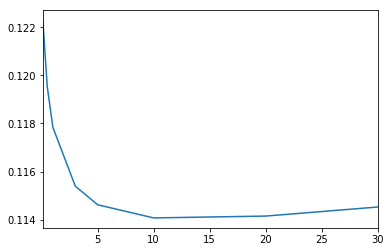

0.11407227815394316

In [123]:
#线性模型
from sklearn.linear_model import Ridge, RidgeCV, ElasticNet, Lasso, LassoLarsCV

# Ridge
alphas = [0.1,0.5,1, 3, 5,10,20,30]
cv_ridge = [rmse_cv(Ridge(alpha = alpha)).mean() for alpha in alphas]
cv_ridge = pd.Series(cv_ridge, index = alphas)
cv_ridge.plot()
plt.show()
cv_ridge.min()
#在alpha=10时取得最小值,0.114

c:\users\xn070393\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_validation.py:458: UserWarning: With alpha=0, this algorithm does not converge well. You are advised to use the LinearRegression estimator
  estimator.fit(X_train, y_train, **fit_params)
c:\users\xn070393\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:477: UserWarning: Coordinate descent with no regularization may lead to unexpected results and is discouraged.
  positive)
c:\users\xn070393\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\xn070393\appdata\local\programs\python\python35\lib\site-packages\sklearn\model_selection\_validation.py:458: UserWarning: With alpha=0, this algorithm 

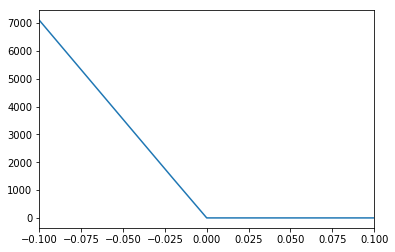

0.11267231654209224

In [138]:
#lasso
alphas = [-0.1,-0.02,0, 0.0001, 0.0002,0.005,0.01,0.1]
cv_lasso = [rmse_cv(Lasso(alpha = alpha)).mean() for alpha in alphas]
cv_lasso = pd.Series(cv_lasso, index = alphas)
cv_lasso.plot()
plt.show()
cv_lasso.min()
#最小值0.112

c:\users\xn070393\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\xn070393\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)
c:\users\xn070393\appdata\local\programs\python\python35\lib\site-packages\sklearn\linear_model\coordinate_descent.py:491: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Fitting data with very small alpha may cause precision problems.
  ConvergenceWarning)


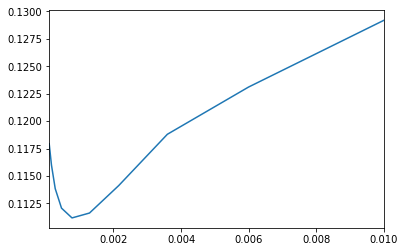

0.11118008893461021

In [142]:
# ElasticNet
alphas = np.logspace(-4, -2, 10)
cv_elastic = [rmse_cv(ElasticNet(alpha=alpha)).mean() for alpha in alphas]
cv_elastic = pd.Series(cv_elastic, index=alphas)
cv_elastic.plot()
plt.show()
cv_elastic.min()

In [ ]:
from sklearn.svm import SVR
svm_model = SVR()

cs = [0.0001, 0.0005, 0.0008, 0.01, 0.02]
cv_svm = [rmse_cv(SVR(C = c, kernel='linear')).mean() for c in cs]
cv_svm = pd.Series(cv_svm, index=cs)
cv_svm.plot()
plt.show()